### Torus Geometry
- **Triangular unit cell**: Primitive vectors G₁ = (G, 0), G₂ = (-G/2, √3G/2)
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Filling Factor
- **ν**: Filling factor 1/3 or others (Laughlin state)
- **Nk**: Number of k-points must be multiple of m for commensurability
- **Ne = Nk * ν**: Number of electrons for ν filling

### Interaction Details
- **Form factor**: V(q) = W₀ × 1/|ql| × tanh(|qD|)
- **Screening**: D/l (finite screening length)
- **Landau level projection**: exp(-0.5 × q²l²) form factor
- **Units**: Energy in units of W₀, length in units of magnetic length l

### Key Physics
- **Magnetic translation algebra**: Implements proper commutation relations
- **Periodic boundary conditions**: Torus geometry with modular parameter τ
- **Momentum conservation**: Total momentum K = (K₁, K₂) is conserved
- **Ground state degeneracy**: m-fold degenerate on torus for Laughlin states

In [20]:
# Define 3×5 k-mesh (Nk=15) for 1/3 filling Laughlin state calculation
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]

# System parameters
Nk = 15         # Total number of k-points
Gk = (3, 5)     # Grid dimensions (G1_direction, G2_direction)
Ne = 5          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

5

In [21]:
# Define 3×6 k-mesh (Nk=18) for 1/3 filling Laughlin state calculation

#=

k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]

# System parameters
Nk = 18         # Total number of k-points
Gk = (3, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 6          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

=#

In [22]:
# Define k-mesh for triangular lattice
# Using 9×9 k-mesh (Nk=27) for accurate Laughlin state calculation
# Note: This setup needs much more time and memory

#=

k_list = [0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

# System parameters
Nk = 27          # Total number of k-points
Gk = (9, 9)      # Grid dimensions (G1_direction, G2_direction)
# Number of electrons for 1/3 filling
Ne = 9          # N electrons for this system

=#

In [23]:
# Define k-mesh for triangular lattice
# Using 6×5 k-mesh (Nk=30) for accurate Laughlin state calculation
# Note: This setup needs much more time and memory
# Note: for 10/30 filling, 36GB memory is recommended

#=

k_list = [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5;
          0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4]

# System parameters
Nk = 30         # Total number of k-points
Gk = (6, 5)      # Grid dimensions (G1_direction, G2_direction)
Ne = 10         # N electrons for this system

=#

In [24]:
# Import the momentum-conserved exact diagonalization package
using MomentumED

# Physical parameters for the FQH system
Gl = sqrt(2π/sqrt(0.75))  # Magnetic length scale from Brillouin zone area
D_l = 5.0                  # Screening length / magnetic length (D/l = 5)
W0 = 1.0                   # Interaction strength (energy unit)
G12_angle = 2π/3          # Angle between reciprocal lattice vectors (triangular lattice)

# Define the form factor for Coulomb interaction in Landau level
# This is the Fourier transform of the projected Coulomb interaction
# V(q) = W₀ * 1/|ql| * tanh(|qD|) * exp(-0.5 * q²l²)
# The exp(-0.5 * q²l²) factor comes from Landau level projection
function VFF(q1::Float64, q2::Float64)
    ql = sqrt(q1^2 + q2^2 + 2cos(G12_angle) * q1*q2) * Gl  # |q| in magnetic length units
    if ql == 0.0
        return W0 * D_l  # Regularization at q=0 (divergent part)
    end
    return W0 / ql * tanh(ql * D_l) * exp(-0.5 * ql^2)
end

# Sign function for reciprocal lattice vectors
# This implements the phase structure of the magnetic translation group
# The sign depends on the parity of the reciprocal lattice vector indices
function ita(g1::Int64, g2::Int64)
    if iseven(g1) && iseven(g2)
        return 1
    else
        return -1
    end
end

# Cross product for 2D vectors (returns scalar z-component)
# Used for computing geometric phases in the magnetic translation algebra
function ql_cross(q1_1, q1_2, q2_1, q2_2)
    return q1_1 * q2_2 - q1_2 * q2_1
end

# Two-body interaction matrix element
# This implements the full Coulomb interaction with proper magnetic translation phases
# The interaction is computed in momentum space with Landau level projection
# Momentum inputs are Tuple(Float64, Float64) representing (k1, k2) in ratio of Gk
function V_int(kf1, kf2, ki2, ki1, cf1=1, cf2=1, ci2=1, ci1=1; output=false)::ComplexF64
    
    # Calculate momentum transfer (modulo reciprocal lattice)
    q = rem.(ki1 .- kf1, 1, RoundNearest)
    G_shift1 = round.(Int64, ki1 .- kf1 .- q, RoundNearest)
    G_shift2 = round.(Int64, kf2 .- ki2 .- q, RoundNearest)

    V_total = ComplexF64(0.0)
    # Sum over reciprocal lattice vectors for convergence
    # Nshell = 2 provides good convergence for this system
    Nshell = 2
    for g1 in -Nshell:Nshell, g2 in -Nshell:Nshell
        if abs(g1-g2) > Nshell
            continue
        end

        # Construct the full momentum transfer including reciprocal lattice
        qq1 = q[1] + g1
        qq2 = q[2] + g2

        # Calculate phase factors from magnetic translation algebra
        # These phases ensure proper commutation relations and gauge invariance
        phase_angle = 0.5ql_cross(ki1[1], ki1[2], kf1[1], kf1[2])
        phase_angle += 0.5ql_cross(ki1[1]+kf1[1], ki1[2]+kf1[2], qq1, qq2)
        phase_angle += 0.5ql_cross(ki2[1], ki2[2], kf2[1], kf2[2])
        phase_angle += 0.5ql_cross(ki2[1]+kf2[1], ki2[2]+kf2[2], -qq1, -qq2)

        phase = cispi(2.0phase_angle)
        sign = ita(g1+G_shift1[1], g2+G_shift1[2]) * ita(g1+G_shift2[1], g2+G_shift2[2])

        V_total += sign * phase * VFF(qq1, qq2)
    end

    return V_total
end

# Create parameter structure for the exact diagonalization
# This contains all the system information needed for the calculation
para = EDPara(k_list = k_list, Gk = Gk, V_int = V_int);

In [25]:
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para, ED_mbslist(para, (Ne,)));
length.(blocks)

15-element Vector{Int64}:
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200

In [26]:
scat_list2 = ED_sortedScatteringList_twobody(para);

In [27]:
Neigen = 5  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat_list2; N = Neigen,
        showtime=true, 
    )
end

Processing block #1 with size 201, momentum 0, 0
  0.121368 seconds (329.51 k allocations: 11.147 MiB, 624.85% compilation time)
  0.003878 seconds (2.65 k allocations: 1.283 MiB)
Processing block #2 with size 200, momentum 0, 1
  0.025194 seconds (200.05 k allocations: 4.688 MiB, 87.75% gc time)
  0.002148 seconds (2.07 k allocations: 1.004 MiB)
Processing block #3 with size 200, momentum 0, 2
  0.002600 seconds (200.08 k allocations: 4.689 MiB)
  0.001572 seconds (1.59 k allocations: 787.698 KiB)
Processing block #4 with size 200, momentum 0, 3
  0.002919 seconds (200.04 k allocations: 4.688 MiB)
  0.001645 seconds (1.60 k allocations: 787.433 KiB)
Processing block #5 with size 200, momentum 0, 4
  0.002947 seconds (200.06 k allocations: 4.688 MiB)
  0.002532 seconds (2.06 k allocations: 1.004 MiB)
Processing block #6 with size 201, momentum 1, 0
  0.015671 seconds (201.69 k allocations: 4.737 MiB, 82.82% gc time)
  0.002518 seconds (2.64 k allocations: 1.284 MiB)
Processing block #7

In [28]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

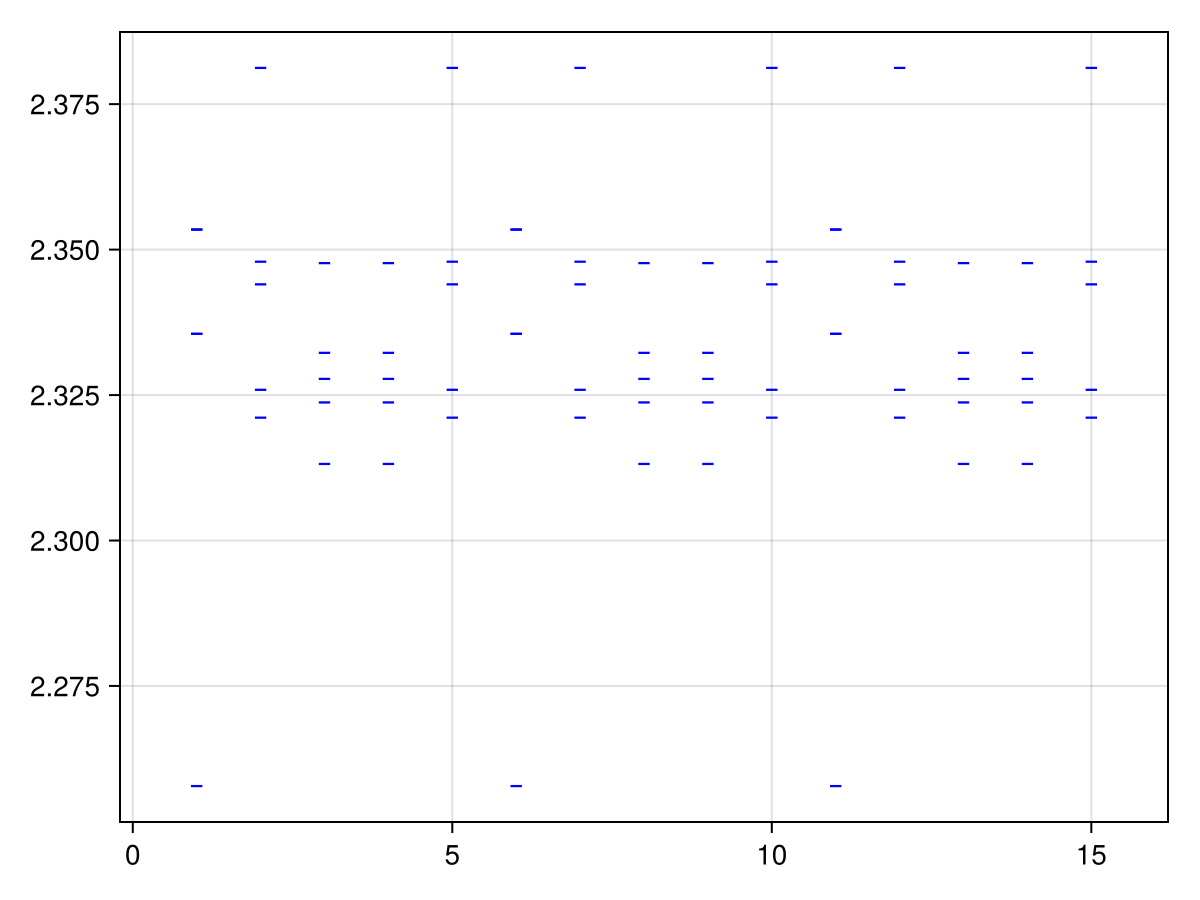

In [29]:
# Plot the energy spectrum
using CairoMakie
CairoMakie.activate!()

begin
    fig = Figure();
    ax = Axis(fig[1, 1])
    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, i, e, color = :blue, marker=:hline)
        end
    end
    xlims!(-0.2, 1.2+length(blocks))
    fig
end

In [33]:
# check energies explicitly to see if there's degeneracy in the same momentum sector.
bn = 1 # the block number to inspect
energies[bn]

5-element Vector{Float64}:
 2.257788292407563
 2.3355172012841594
 2.335517201284163
 2.353444864262791
 2.3534448642627934

Compute and plot one-body reduced density matric

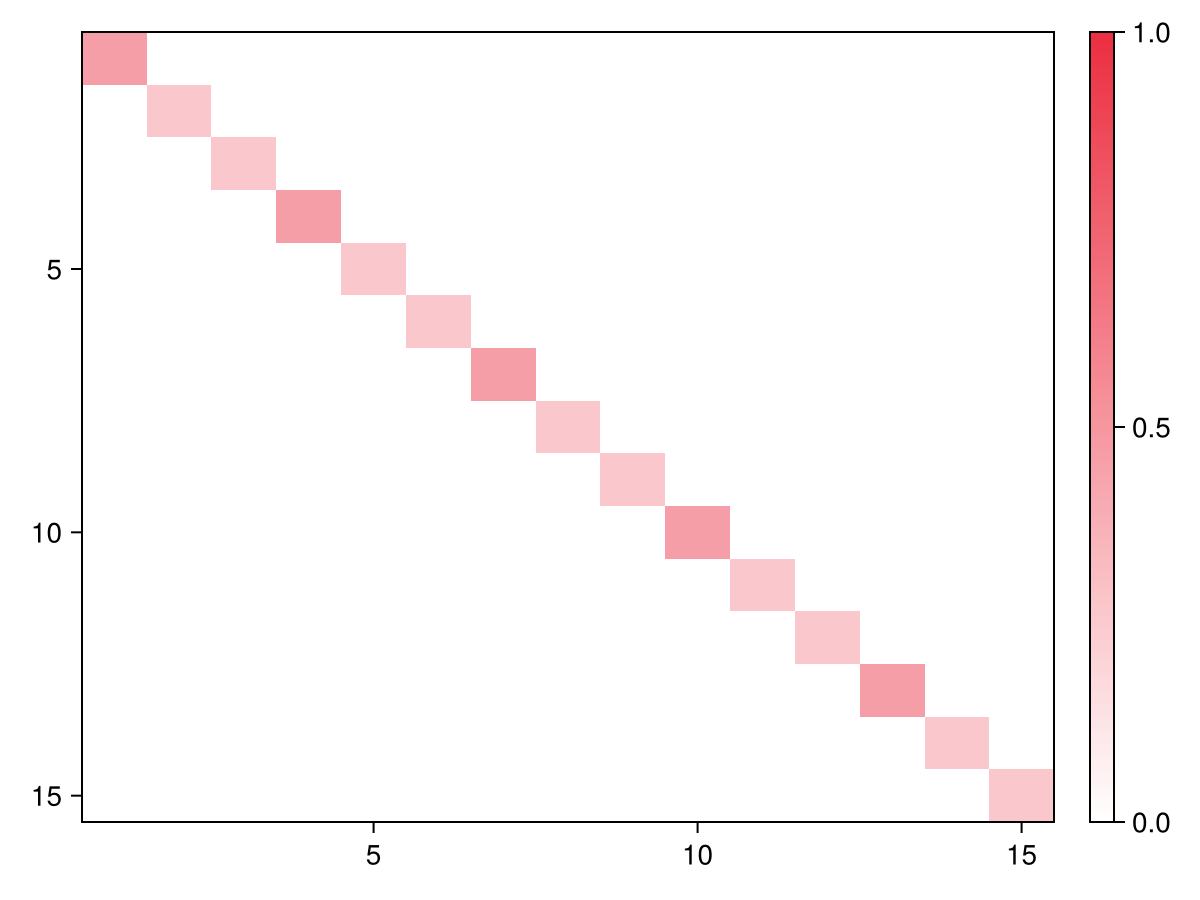

In [34]:
# plot the one-body reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])
begin
    fig = Figure();
    ax = Axis(fig[1, 1]; yreversed = true)
    hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    fig
end

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [31]:
# Define the Landau level infinitesimal form factor
function Landau_ff_inf(k_f, k_i, c=1)
    dk = k_f .- k_i
    k = 0.5 .* (k_f .+ k_i)
    return -π * (k[1]*dk[2] - k[2]*dk[1])
end
para.FF_inf_angle = Landau_ff_inf; # Update the form factor in the parameter

In [32]:
# boundary twist angle path (Wilson loop)
N_shift = 2  # number of shifts along each edge
shifts = Tuple{Float64, Float64}[(0.0, 0.0)]
for i in 1:N_shift
    push!(shifts, (i/N_shift, 0.0))
end
for i in 1:N_shift
    push!(shifts, (1.0, i/N_shift))
end
for i in 1:N_shift
    push!(shifts, ((N_shift - i)/N_shift, 1.0))
end
for i in 1:N_shift
    push!(shifts, (0.0, (N_shift - i)/N_shift))
end
shifts

9-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.5, 0.0)
 (1.0, 0.0)
 (1.0, 0.5)
 (1.0, 1.0)
 (0.5, 1.0)
 (0.0, 1.0)
 (0.0, 0.5)
 (0.0, 0.0)

If there's only one ground state.

In [15]:
psi_before = copy(vectors[bn][1])
psi_before *= cis(-angle(psi_before[1]))  # fix global phase

WilsonLoopIntegral= Vector{Float64}(undef, 4N_shift)
for i in eachindex(WilsonLoopIntegral)

    println("k_shift #$i \t $(shifts[i+1])")

    # one-body term is all zero and not changed by k-shift
    scat_list2 = ED_sortedScatteringList_twobody(para; kshift = shifts[i+1]);
    psi_after = EDsolve(blocks[bn], scat_list2; N = 1,
        showtime = true,
    )[2][1]
    psi_after *= cis(-angle(psi_after[1]))  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn], 
        psi_after, psi_before, shifts[i+1], shifts[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before = psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π)

k_shift #1 	 (0.3333333333333333, 0.0)
  0.027690 seconds (1.94 M allocations: 44.237 MiB)
  0.034251 seconds (100.00 k allocations: 8.085 MiB, 69.67% compilation time: 100% of which was recompilation)
Inner product: amp = 0.9326829013840181, phase = -0.6854042154624329
k_shift #2 	 (0.6666666666666666, 0.0)
  0.067834 seconds (1.94 M allocations: 44.557 MiB, 12.79% gc time)
  0.006880 seconds (1.38 k allocations: 3.078 MiB)
Inner product: amp = 0.9144199031546625, phase = -0.6623452484981368
k_shift #3 	 (1.0, 0.0)
  0.027391 seconds (1.94 M allocations: 44.235 MiB, 9.38% gc time)
  0.007103 seconds (1.44 k allocations: 3.116 MiB)
Inner product: amp = 0.8166285873418806, phase = -0.428289475069685
k_shift #4 	 (1.0, 0.3333333333333333)
  0.026988 seconds (1.94 M allocations: 44.234 MiB, 15.29% gc time)
  0.006408 seconds (1.42 k allocations: 3.114 MiB)
Inner product: amp = 0.6574702043503129, phase = -1.036460115334932
k_shift #5 	 (1.0, 0.6666666666666666)
  0.034860 seconds (1.94 M 

┌ Warning: Small inner product amplitude: 0.6574702043503129
└ @ MomentumED C:\Users\zoubo\PhysicsWorking\MomentumED.jl\src\analysis\manybody_connection.jl:89


  0.010107 seconds (1.52 k allocations: 3.123 MiB)
Inner product: amp = 0.8856248762343892, phase = -0.934388249408912
k_shift #7 	 (0.6666666666666666, 1.0)
  0.032208 seconds (1.94 M allocations: 44.234 MiB, 12.55% gc time)
  0.010316 seconds (1.43 k allocations: 3.115 MiB)
Inner product: amp = 0.48750205886068093, phase = 1.1131138964374583
k_shift #8 	 (0.3333333333333333, 1.0)


┌ Warning: Small inner product amplitude: 0.48750205886068093
└ @ MomentumED C:\Users\zoubo\PhysicsWorking\MomentumED.jl\src\analysis\manybody_connection.jl:89


  0.032262 seconds (1.94 M allocations: 44.242 MiB, 12.76% gc time)
  0.012978 seconds (1.43 k allocations: 3.116 MiB)
Inner product: amp = 0.7274703703864887, phase = -0.024756894660908014
k_shift #9 	 (0.0, 1.0)
  0.038626 seconds (1.94 M allocations: 44.234 MiB, 19.49% gc time)
  0.009747 seconds (1.43 k allocations: 3.116 MiB)
Inner product: amp = 0.20063231320276625, phase = 2.132430699941098
k_shift #10 	 (0.0, 0.6666666666666666)


┌ Warning: Small inner product amplitude: 0.20063231320276625
└ @ MomentumED C:\Users\zoubo\PhysicsWorking\MomentumED.jl\src\analysis\manybody_connection.jl:89


  0.032690 seconds (1.94 M allocations: 44.235 MiB, 16.81% gc time)
  0.013674 seconds (2.44 k allocations: 5.169 MiB)
Inner product: amp = 0.7021287014123446, phase = 1.2080378615889371
k_shift #11 	 (0.0, 0.3333333333333333)
  0.030885 seconds (1.94 M allocations: 44.235 MiB, 9.74% gc time)
  0.009048 seconds (1.43 k allocations: 3.115 MiB, 11.39% gc time)
Inner product: amp = 0.2207740003957221, phase = -1.5593834835228144
k_shift #12 	 (0.0, 0.0)


┌ Warning: Small inner product amplitude: 0.2207740003957221
└ @ MomentumED C:\Users\zoubo\PhysicsWorking\MomentumED.jl\src\analysis\manybody_connection.jl:89


  0.032696 seconds (1.94 M allocations: 44.235 MiB, 17.93% gc time)
  0.008749 seconds (1.45 k allocations: 3.115 MiB)
Inner product: amp = 0.923895478902595, phase = 0.12681211612487256


0.2478175797944368

If there're 3 ground states in the same total momentum section, we need to use multiple wavefunctions with non-Abelian calculation function.

In [45]:
psi_before = reduce(hcat, vectors[bn][1:3])
for i in 1:3
    psi_before[:, i] *= cis(-angle(psi_before[1, i]))  # fix global phase
end

using LinearAlgebra
WilsonLoopIntegral= Array{ComplexF64, 3}(undef, 3, 3, 4N_shift)
for i in axes(WilsonLoopIntegral, 3)

    println("k_shift #$i \t $(shifts[i+1])")

    if shifts[i+1] == (0.0, 0.0)
        psi_after = reduce(hcat, vectors[bn][1:3])
        for i in 1:3
            psi_after[:, i] *= cis(-angle(psi_after[1, i]))  # fix global phase
        end
    else
        # one-body term is all zero and not changed by k-shift
        scat_list2 = ED_sortedScatteringList_twobody(para; kshift = shifts[i+1]);
        vecs = EDsolve(blocks[bn], scat_list2; N = 6,
            showtime = false, #vec0 = psi_before[:, 1],
        )[2][1:3]
        psi_after = reduce(hcat, vecs)
        for j in 1:3
            psi_after[:, j] *= cis(-angle(psi_after[1, j]))  # fix global phase
        end
    end

    WilsonLoopIntegral[:, :, i] = ED_NAconnection_step(blocks[bn],
        psi_after, psi_before, shifts[i+1], shifts[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before = psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral, dims = 3) ./ (2π)
eigvals(ManyBodyChernNumber[:,:,1])

k_shift #1 	 (0.5, 0.0)
Inner product: amp = 0.9865902958964128, phase = [-0.6371049676630481, -0.42710306044847984, 2.2595487127032046]
k_shift #2 	 (1.0, 0.0)
Inner product: amp = 0.9865902958964128, phase = [-1.665862873507085, -0.6254468060748164, -0.40711330068951934]
k_shift #3 	 (1.0, 0.5)
Inner product: amp = 0.9893453187448077, phase = [-0.4167163434430667, -0.3812073692184182, 0.15679096731826653]
k_shift #4 	 (1.0, 1.0)
Inner product: amp = 0.9893453187448067, phase = [-0.41671634344306685, -0.26670328638373225, 2.469859147165896]
k_shift #5 	 (0.5, 1.0)
Inner product: amp = 0.986590295896412, phase = [-0.248701533884309, 0.004856664538336392, 0.4484938369214196]
k_shift #6 	 (0.0, 1.0)
Inner product: amp = 0.9865902958964123, phase = [-1.0921182731793762, -0.02550066472293472, 0.2666149384878953]
k_shift #7 	 (0.0, 0.5)
Inner product: amp = 0.989345318744807, phase = [-0.2690846202850226, -0.10688243215523, 0.6458824508609521]
k_shift #8 	 (0.0, 0.0)
Inner product: amp = 0.

3-element Vector{Float64}:
 -0.33391561664407987
 -0.3221051584828727
  0.6560207751269536

In [46]:
real.(ManyBodyChernNumber)

3×3×1 Array{Float64, 3}:
[:, :, 1] =
 -0.333262   -0.0108002   0.0107326
 -0.0108002   0.105707   -0.485077
  0.0107326  -0.485077    0.227556

In [47]:
imag.(ManyBodyChernNumber)

3×3×1 Array{Float64, 3}:
[:, :, 1] =
  0.0         0.0110032   -0.0109141
 -0.0110032   0.0          0.00505737
  0.0109141  -0.00505737   0.0

In [42]:
using LinearAlgebra
⊗ = kron
[1; 0; 0] ⊗ vectors[1][1]

603-element Vector{ComplexF64}:
    0.04291965738732439 + 0.08074620393314985im
    -0.0490304784295488 + 0.0949490594649567im
   -0.10743222470930042 - 8.00436147099462e-5im
  0.0010865089299951912 - 0.004536620093692045im
  -0.030971941763656138 + 0.057580045481467786im
    0.09054499714867714 - 0.04779415092235248im
    0.03185233569968514 + 0.04465641317815125im
     0.0366252352872821 - 0.021462158118495354im
  0.0017875541974196106 + 0.004308836678355392im
 -0.0068086990664843194 - 0.032603942995458234im
                        ⋮
                    0.0 - 0.0im
                   -0.0 - 0.0im
                   -0.0 + 0.0im
                   -0.0 - 0.0im
                    0.0 - 0.0im
                   -0.0 - 0.0im
                    0.0 - 0.0im
                    0.0 - 0.0im
                   -0.0 - 0.0im